## This notebook will guide you through the use of the chronix2grid API. You'll be able to separately generate loads, renewable productions and the corresponding dispatch of the other generators.

For more information about chronix2grid, you can read its documentation here: https://chronix2grid.readthedocs.io/en/latest/

<div class="alert alert-block alert-warning">
    <b>WARNING</b>: If you run <b>chronix2grid in a virtual env</b>, make sure that you either:
    
    - sourced your virtual env before launching jupyter: source v_env_chronix2grid/bin/activate
    
    - created an ipython kernel for this virtual env, and that you are actually running this kernerl now
</div>


In [2]:
import os
import sys

import cufflinks as cf

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline
print("This notebook uses the last version of grid2op. You can install it with:\n"\
      "\t{} -m pip install grid2op".format(sys.executable))
import grid2op
if grid2op.__version__ < "0.6.0":
    raise RuntimeError("Impossible to run this notebook without grid2op version 0.6.0 installed.")
from grid2op.Chronics import ChangeNothing
from grid2op.Plot import PlotMatplotlib

from chronix2grid.GeneratorBackend import GeneratorBackend
import chronix2grid.generation.generate_chronics as gen
import chronix2grid.generation.generation_utils as gu
import chronix2grid.generation.consumption.generate_load as gen_loads
import chronix2grid.generation.renewable.generate_solar_wind as gen_enr
import chronix2grid.generation.dispatch.generate_dispatch as gen_dispatch
import chronix2grid.generation.dispatch.utils as du

from PypsaDispatchBackend.PypsaEconomicDispatch import PypsaDispatcher
#import PypsaDispatchBackend.PypsaEconomicDispatch as ec
from PypsaDispatchBackend.EDispatch_L2RPN2020 import run_economic_dispatch
import chronix2grid.kpi.main as kpis
from chronix2grid.main import create_directory_tree
import chronix2grid.constants as cst

This notebook uses the last version of grid2op. You can install it with:
	/usr/bin/python3 -m pip install grid2op


In [3]:
compute_kpis = True  # The computation of KPIs can take some time...
seed_reproducible = True  # Make sure to use the same seeds to reproduce results

You can checkout the chronix2grid workflow in the documentation here:
https://chronix2grid.readthedocs.io/en/latest/GETTING_STARTED.html#workflow-and-model-interface


Here are the outputs you will get: generated timeseries and kpis computed on those chronics compared to reference chronics. This will help the calibration process we will achieve within this notebook.

<img src="../pictures/ChroniX2Grid_ouputs.png" width=1000 > 

# Parameters

## General parameters

In [4]:
### CONSTANT

notebook_folder=%pwd

# define your input folder
INPUT_FOLDER = os.path.join(notebook_folder, 'example', 'input')
#INPUT_FOLDER=os.path.join(notebook_folder, '../input_data')

OUTPUT_FOLDER = os.path.join(notebook_folder, 'example', 'output')
#OUTPUT_FOLDER = os.path.join(notebook_folder, '..', 'output')

# Detailed configuration to be set in <INPUT_FOLDER>/<CASE>/params.json
start_date = "2012-01-01"
weeks = 52
n_scenarios = 1
by_n_weeks = 4


CASE = 'case118_l2rpn_wcci'
path_case = os.path.join(INPUT_FOLDER, 'generation', CASE)
grid_path = os.path.join(path_case, "grid.json")

generation_output_folder, kpi_output_folder = create_directory_tree(
    CASE, start_date, OUTPUT_FOLDER, cst.SCENARIO_FOLDER_BASE_NAME, n_scenarios, 
    'LRTK', warn_user=False)

# Load the grid (through grid2Op)

you will here load the grid where we localized productions and consumptions to get some information about your input data for the generation process

<img src="../pictures/ChroniX2Grid_inputs.png" width=1000 > 

In [5]:
env118_withoutchron = grid2op.make(
    "rte_case118_example",
    test=True,
    grid_path=grid_path, # assign it the 118 grid
    chronics_class=ChangeNothing, # tell it to change nothing (not the most usable environment...)
)

/home/gaetan/.local/lib/python3.8/site-packages/grid2op/MakeEnv/Make.py:305: UserWarning:

You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.



# Check the Energy Mix apriori

In [6]:
%run ../chronix2grid/kpi/Generator_parameter_checker.py
Target_EM_percentage=pd.DataFrame(data=[7,10.5,40,18,22.5],columns=['target_energy_mix'],
                                  index=['solar','wind','nuclear','hydro','thermal'])

#data=[4,6,40,18,30]

#Variable used to anticipate the energy mix a priori. Update them after chronics generation if too different
PeakLoad = 4200 #expected peak load
AverageLoad = 2800 #expected average load

CapacityFactor=pd.DataFrame(data=[15,25,95,30,np.nan],columns=['capacity_factor'],
                            index=['solar','wind','nuclear','hydro','thermal'])
Capacity_df=EnergyMix_AprioriChecker(env118_withoutchron,Target_EM_percentage, PeakLoad, AverageLoad, CapacityFactor )
Capacity_df

,target_energy_mix,pmax,capacity_mix,capacity_factor,Apriori_energy_mix,revised_pmax
solar,7.0,746.399963,10.0,15.0,3.998571,1306.666667
wind,10.5,672.000000,9.0,25.0,6.000000,1176.000000
nuclear,40.0,1200.000000,16.1,95.0,40.714286,1178.947368
hydro,18.0,1750.000000,23.4,30.0,18.750000,1680.000000
thermal,22.5,3100.000000,41.5,NaN,30.537143,3021.052632


# II Generate the data

**You can set generation configuration such as number of scenarios, start date, number of weeks, noise intensities, timestep... in INPUT_FOLDER/CASE/params.json**

In [6]:
if seed_reproducible:
    seeds = [181791698]  # for reproducibility - otherwise comment here and uncomment below
else:
    seeds = [np.random.randint(low=0, high=2**31) for _ in range(n_scenarios)]

In [7]:
#generating scenario names
scen_name_generator = gu.folder_name_pattern(cst.SCENARIO_FOLDER_BASE_NAME, n_scenarios)

In [8]:
## Reading time parameters
generator = GeneratorBackend()
generation_input_folder=os.path.join(INPUT_FOLDER, 'generation')
time_params = gu.time_parameters(weeks, start_date)
print(time_params)

{'weeks': 52, 'start_date': Timestamp('2012-01-01 00:00:00'), 'year': 2012}


In [9]:
## Reading general parameters


general_config_manager = generator.general_config_manager(
    name="Global Generation",
    root_directory=generation_input_folder,
    input_directories=dict(case=CASE),
    required_input_files=dict(case=['params.json']),
    output_directory=generation_output_folder
)
general_config_manager.validate_configuration()
params = general_config_manager.read_configuration()

params.update(time_params)
params = gu.updated_time_parameters_with_timestep(params, params['dt'])
print(params)



{'dt': 5.0, 'planned_std': 0.01, 'weeks': 52, 'start_date': Timestamp('2012-01-01 00:00:00'), 'year': 2012, 'end_date': Timestamp('2012-12-29 23:55:00'), 'T': 524155}


# II A) Generate loads and renewables

Read more about load generation configuration here and its API to plug-in any other model: https://chronix2grid.readthedocs.io/en/latest/INTERFACE.html#module-chronix2grid.generation.consumption.ConsumptionGeneratorBackend

In [10]:
# Separate generation for load and renewables
load_config_manager = generator.load_config_manager(
    name="Loads Generation",
    root_directory=generation_input_folder,
    input_directories=dict(case=CASE, patterns='patterns'),
    required_input_files=dict(case=['loads_charac.csv', 'params_load.json'],
                              patterns=['load_weekly_pattern.csv']),
    output_directory=generation_output_folder
)
load_config_manager.validate_configuration()
params_load, loads_charac = load_config_manager.read_configuration()
print(params_load)

params_load.update(params)

{'Lx': 1000.0, 'Ly': 1000.0, 'dx_corr': 250.0, 'dy_corr': 250.0, 'temperature_corr': 400.0, 'std_temperature_noise': 0.06}


Read about the default load generation model here: https://chronix2grid.readthedocs.io/en/latest/DESCRIPTION.html#load-generation
        

In [11]:


# Launch load generation
for i, seed in enumerate(seeds):
    scenario_name = scen_name_generator(i)
    scenario_folder_path = os.path.join(generation_output_folder, scenario_name)
    print("================ Generating scenario number "+str(i)+" ================")
    #load, load_forecasted = gen_loads.main(scenario_folder_path, seed, params, loads_charac, 
    #                                       load_weekly_pattern, write_results = True)
    
    load, load_forecasted = generator.do_l(scenario_folder_path, seed, params_load,
                                           loads_charac, load_config_manager)


    print('\n')
params.update(params_load)

================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...


## Check load hypothesis (peak and average)

**if this differs by too much, you should update the computation of the Energy Mix a priori and revise some calibration if not satisfactory**

In [ ]:
CurrentPeakLoad = load.sum(axis=1).max()
print('the expected peak load was: ' + str(PeakLoad))
print('the actual peak load is: ' + str(CurrentPeakLoad))

the expected peak load was: 4200
the actual peak load is: 4263.570411100756


In [ ]:
CurrentAverageLoad = load.sum(axis=1).mean()
print('the expected average load was: ' + str(AverageLoad))
print('the actual average load is: ' + str(CurrentAverageLoad))

the expected average load was: 2800
the actual average load is: 2815.4225663436087


## Generate Renewables

Read more about renewable generation configuration here and its API to plug-in any other model: https://chronix2grid.readthedocs.io/en/latest/INTERFACE.html#module-chronix2grid.generation.renewable.RenewableBackend

In [ ]:
res_config_manager = generator.res_config_manager(
    name="Renewables Generation",
    root_directory=generation_input_folder,
    input_directories=dict(case=CASE, patterns='patterns'),
    required_input_files=dict(case=['prods_charac.csv', 'params_res.json'],
                              patterns=['solar_pattern.npy']),
    output_directory=generation_output_folder
)
params_res, prods_charac = res_config_manager.read_configuration()
print(params_res)
params_res.update(params)


{'Lx': 1000.0, 'Ly': 1000.0, 'dx_corr': 250.0, 'dy_corr': 250.0, 'long_wind_corr': 5000.0, 'medium_wind_corr': 720.0, 'short_wind_corr': 120.0, 'solar_corr': 20.0, 'smoothdist': 0.001, 'std_solar_noise': 0.4, 'std_short_wind_noise': 0.1, 'std_medium_wind_noise': 0.15, 'std_long_wind_noise': 0.2, 'year_solar_pattern': 2007.0}


Read about the default renewable generation model here: https://chronix2grid.readthedocs.io/en/latest/DESCRIPTION.html#pattern-based-methods-with-spatio-temporal-correlated-noise
        

In [ ]:
# Launch solar and wind generation
for i, seed in enumerate(seeds):
    print("================ Generating scenario number "+str(i)+" ================")
    
    scenario_name = scen_name_generator(i)
    scenario_folder_path = os.path.join(generation_output_folder, scenario_name)
    
    generator.do_r(scenario_folder_path, seed, params_res,prods_charac,res_config_manager)
    
    prod_solar, prod_solar_forecasted, prod_wind, prod_wind_forecasted = generator.do_r(scenario_folder_path, seed,
                                                                                        params_res,prods_charac,res_config_manager)
    print('\n')
params.update(params_res)


================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv




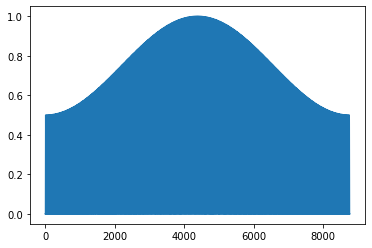

In [ ]:
solar_pattern=res_config_manager.read_specific()
plt.plot(solar_pattern)

## Check Ramps and Pmin/Pmax Generator parameters A priori

In [ ]:
dispath_config_manager = generator.dispatch_config_manager(
    name="Dispatch",
    root_directory=generation_input_folder,
    output_directory=generation_output_folder,
    input_directories=dict(params=CASE),
    required_input_files=dict(params=['params_opf.json'])
)
dispath_config_manager.validate_configuration()
params_opf = dispath_config_manager.read_configuration()

### Select the scenario you want to check first

In [ ]:
generation_output_folder

'/home/gaetan/Documents/Projects/ChroniX2Grid/getting_started/example/output/generation/case118_l2rpn_icaps_2x/2012-01-01'

In [ ]:
%run ../chronix2grid/kpi/Generator_parameter_checker.py

losses_pct = params_opf["losses_pct"]  # losses as pct of load
[isThermalInTrouble, isNuclearInTrouble, IsRampUpInTrouble, IsRampDownInTrouble] = Ramps_Pmax_Pmin_APrioriCheckers(
    env118_withoutchron, Capacity_df, generation_output_folder, losses_pct, PeakLoad)


 the wind share is 10.6
the wind share was expected to be 10.5
the solar share is 7.2
the solar share was expected to be 7.0

 the max load is 4280.7548
the expected peak load was 4200

 the max net load is 3842.2712

 the min net load is 702.7679999999999
the nuclear capacity is 1200.0
the max net load decrease 160.11000000000058
the nuclear max ramp Down is 8.4
are we in trouble for nuclear:True

 the max net load ramp up is 160.11000000000058
the max generation ramp up is 165.29999

 the max net load ramp down is -173.8875999999998
the max nuclear + hydro ramp down is 81.19999504089355


/home/gaetan/Documents/Projects/ChroniX2Grid/chronix2grid/kpi/Generator_parameter_checker.py:220: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
print("Are the thermal reactors \"in trouble\": {}".format(isThermalInTrouble))
print("Are the nuclear reactors \"in trouble\": {}".format(isNuclearInTrouble))
print("Are the ramp up \"in trouble\": {}".format(IsRampUpInTrouble))
print("Are the ramp down \"in trouble\": {}".format(IsRampDownInTrouble))

Are the thermal reactors "in trouble": False
Are the nuclear reactors "in trouble": True
Are the ramp up "in trouble": False
Are the ramp down "in trouble": False


In [ ]:
%run ../chronix2grid/kpi/Generator_parameter_checker.py
Aposteriori_renewableCapacityFactor_Checkers(env118_withoutchron, Capacity_df, generation_output_folder)


 the max wind production 715.3000000000002

 the expected max wind production was 1344.0

 the max solar production 1007.1

 the expected max solar production was 1493.6

 the solar capacity factor is: 0.13555570242847217

 the expected solar capacity factor was: 15.0

 the wind capacity factor is: 0.22262966064768192

 the expected wind capacity factor was: 25.0


[0.13555570242847217, 0.22262966064768192]

## Compute some KPIs for solar, wind and load only

#### Benchmark "France" is set as reference in INPUT_FOLDER/kpi/paramsKPI.json
Images are saved in OUTPUT_FOLDER/kpi/CASE/start_date/SCENARIO/images

Read more about available KPIs here: https://chronix2grid.readthedocs.io/en/latest/KPI.html

In [ ]:
# If you just want to save a lot of plots without showing it, uncomment this line.
# If you want to compute more than 1 scenario, it is recommended not to show the plots on notebook
#%%capture
year = time_params['year']
if compute_kpis:
    # Chose number of scenarios to compute KPIs (it can be long to compute it for a lot of scenarios)
    n_scenarios_kpis = 1

    # Computation
    wind_solar_only = True
    scenario_names = gu.folder_name_pattern(cst.SCENARIO_FOLDER_BASE_NAME, n_scenarios_kpis)
    kpis.main(os.path.join(INPUT_FOLDER, cst.KPI_FOLDER_NAME), generation_output_folder,
              scenario_names, kpi_output_folder, year, CASE,
              n_scenarios_kpis, wind_solar_only, params, loads_charac, prods_charac, scenario_id=0)

================================================= KPI GENERATION  ===================================================================
Scenario_0...


FileNotFoundError: [Errno 2] No such file or directory: '/home/gaetan/Documents/Projects/ChroniX2Grid/getting_started/../input_data/kpi/case118_l2rpn_icaps_2x/paramsKPI.json'

## II B) Run an economic dispatch 


<div class="alert alert-block alert-warning">
You need to install the solver that pypsa is calling. For instance cbc solver. On Fedora do `dnf install coin-or-Cbc.x86_64`
</div>


Create The EconomicDispatch instance : a high level wrapper around a Pypsa net

Read more about the Dispatch api here:https://chronix2grid.readthedocs.io/en/latest/INTERFACE.html#module-chronix2grid.generation.dispatch.DispatchBackend 

Read more about dispatch model here: https://chronix2grid.readthedocs.io/en/latest/DESCRIPTION.html#economic-dispatch-generation-hydro-nuclear-and-thermic-generators

In [ ]:
dispatcher = PypsaDispatcher.from_gri2op_env(env118_withoutchron)
dispatcher.modify_marginal_costs({'hydro': 36})
dispatcher.read_hydro_guide_curves(os.path.join(INPUT_FOLDER, 'generation/patterns', 'hydro_french.csv'))

In [ ]:
dispatcher.plot_ramps()

## Dispatch Parameters 

In [ ]:
print(params_opf)

{'step_opf_min': 5, 'mode_opf': 'month', 'reactive_comp': 1, 'losses_pct': 0.4, 'dispatch_by_carrier': False, 'ramp_mode': 'hard', 'pyomo': False, 'solver_name': 'cbc', 'idxSlack': 37, 'nameSlack': 'gen_68_37', 'hydro_ramp_reduction_factor': 1.0, 'slack_p_max_reduction': 150.0, 'slack_ramp_max_reduction': 6.0, 'loss_grid2op_simulation': True, 'agent_type': 'reco', 'early_stopping_mode': False}


### Run opf

In [ ]:
#for scenario_name in os.listdir(generation_output_folder):
for i, seed in enumerate(seeds):
    scenario_name = scen_name_generator(i)
    if scenario_name in ['.DS_Store'] or os.path.isfile(os.path.join(generation_output_folder, scenario_name)):
        continue

    scenario_folder_path = os.path.join(generation_output_folder, scenario_name)
    print(scenario_folder_path)
    dispatcher.read_load_and_res_scenario(
        os.path.join(scenario_folder_path, 'load_p.csv.bz2'),
        os.path.join(scenario_folder_path, 'prod_p.csv.bz2'),
        scenario_name=scenario_name,
        start_date=params['start_date'], end_date=params['end_date'], dt=params['dt']
    )
    hydro_constraints = dispatcher.make_hydro_constraints_from_res_load_scenario()
    agg_load_without_renew = dispatcher.net_load(losses_pct, name=dispatcher.loads.index[0])

    # Example of how to extract info on the largest ramps
    print(f'5 largest ramps reached by the agg_load_without_renew:')
    print(dispatcher.nlargest_ramps(5, losses_pct))

    # Run Economic Disptach using submodule EDisptach_L2RPN_2020
    # **  **  **  **  **  **  **  **  **  **  **  **  **  **
    #dispatch_results = dispatcher.run(
    #    agg_load_without_renew,
    #    params=params_opf,
    #    gen_constraints=hydro_constraints,
    #    ramp_mode=run_economic_dispatch.RampMode.hard,
    #    by_carrier=DispatchByCarrierOnly,  # True to run the dispatch only aggregated generators by carrier,
    #    pyomo=False,
    #    solver_name='cbc'
    #)
    #
    dispatch_results = generator.do_t(generation_input_folder, scenario_name, load, prod_solar, prod_wind,
                             path_case, scenario_folder_path, seed, params, params_opf, loss=None)

    chronix_scenario = dispatch_results.chronix

    # save prods chronics
    #dispatcher.save_results(params, scenario_folder_path)

# TODO if there are failures, write it somewhere, for now it's only detected in the very verbose output cell.
# for example you can do a report at the end 'looking like failures for scenariis xxx'

/home/gaetan/Documents/Projects/ChroniX2Grid/getting_started/example/output/generation/case118_l2rpn_icaps_2x/2012-01-01/Scenario_0
5 largest ramps reached by the agg_load_without_renew:
                             
2012-08-09 14:25:00  160.1100
2012-06-08 11:00:00  149.6360
2012-07-09 09:40:00  148.6188
2012-08-09 14:20:00  137.7732
2012-07-24 11:25:00  136.3228
mode_opf is not None
Preprocessing input data..
Filter generators ramps up/down
Adapting PyPSA grid with parameters..
mode_opf is not None

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.35s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 9.64e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 2


INFO:pypsa.linopf:Total preparation time: 2.16s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 9.09e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 3


INFO:pypsa.linopf:Total preparation time: 2.32s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.95e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 4


INFO:pypsa.linopf:Total preparation time: 2.43s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 7.56e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 5


INFO:pypsa.linopf:Total preparation time: 2.3s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.63e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 6


INFO:pypsa.linopf:Total preparation time: 2.23s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 7


INFO:pypsa.linopf:Total preparation time: 2.27s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.86e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 8


INFO:pypsa.linopf:Total preparation time: 2.29s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Prepare linear problem


** OPF failed to find an optimal solution **

--> OPF formulation by => month - Analyzing month # 9


INFO:pypsa.linopf:Total preparation time: 2.15s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.47e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 10


INFO:pypsa.linopf:Total preparation time: 2.21s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.94e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 11


INFO:pypsa.linopf:Total preparation time: 2.13s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.02e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 12


INFO:pypsa.linopf:Total preparation time: 2.08s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.70e+08


-- opf succeeded  >Objective value (should be greater than zero!
Total time 4.41 min
OPF Done......
Saving results for the grids with individual generators...
applying noise to forecast of 0.01 %
temporary copy of grid in /home/gaetan/Documents/Projects/ChroniX2Grid/getting_started/../input_data/generation/case118_l2rpn_icaps_2x_Scenario_0
temporary copy of chronics in /home/gaetan/Documents/Projects/ChroniX2Grid/getting_started/../input_data/generation/case118_l2rpn_icaps_2x_Scenario_0/chronics/Scenario_0
Start grid2op simulation to compute realistic loss on grid
Grid2op simulation for loss
You might need to install the LightSimBackend (provisory name) to gain massive speed up


episode:  11%|█         | 11345/104830 [05:31<45:30, 34.24it/s] 


KeyboardInterrupt: 

chronix_scenario is an object containing all the time series related to the studied scenario : 
- chronix_scenario.name gives the name of the scenario
- chronix_scenario.wind_p (resp. solar_p, prods_dispatch, loads, marginal_prices) gives the Wind DataFrame (resp. Solar, Dispatched generators, loads, marginal_prices)

This object should be manipulated in the sequel.

### The code below (up until the kpis) will  not run if  run_automated_dispatch = True

In [ ]:
#check that the max net load is similar than after generating loads and renewables
agg_load_without_renew.max()

In [ ]:
#look at the slcack bus generation for case 118
#dispatch_results.chronix.prods_dispatch['gen_68_37'].iplot(kind='scatter', filename='cufflinks/cf-simple-line')

### Check That Pypsa does not violate the ramps

In [ ]:
delta_dispatch=dispatch_results.chronix.prods_dispatch.diff()
months=delta_dispatch.index.month
unique_val,indices=np.unique(months,return_index=True)
list(indices)

In [ ]:
delta_dispatch_no_monthly_rupture=delta_dispatch.drop(delta_dispatch.index[list(indices)])

In [ ]:
#filter out monthly 

StatsRamps=delta_dispatch_no_monthly_rupture.describe()
maxRamps=StatsRamps.loc['max']
maxRamps[maxRamps>=10]

In [ ]:
gen_names=list(env118_withoutchron.name_gen)
matchIDs=[gen_names.index(el) for el in list(StatsRamps)]
gen_ramps=env118_withoutchron.gen_max_ramp_up[matchIDs]
gen_subIds=env118_withoutchron.gen_to_subid[matchIDs]

RampsToHigh=((maxRamps>gen_ramps).values & (gen_ramps!=0))
print('\n generation above their max rated ramps')
print(gen_subIds[RampsToHigh])
print('\n max ramps in environement for generation above their max rated ramps')
print(pd.DataFrame(gen_ramps,index=list(StatsRamps)).loc[RampsToHigh])
print('\n max ramps after pypsa')
print(maxRamps[RampsToHigh])

<div class="alert alert-block alert-warning">
<b>WARNING</b>:The opf mode, 'month' or 'week' for instance' does not insure the consistency between at the border: when switching from one month to the other, the ramps are not right following the ramp constraints for this specific time.
    
As of now, you will need to use an opf-mode on a longer timeframe, if you really want to generate a full year with all constraints checked at all times

Let's see below this little discrepancy here
    
</div>

In [ ]:
Ramps=delta_dispatch_no_monthly_rupture
Ramps.iplot(kind='scatter', filename='cufflinks/cf-simple-line')

### Plot the dispatch

In [ ]:
# Concatenate renewable dispatch

#Becareful:check years of opf_dispatch and dispatch
print(chronix_scenario.wind_p.index[0])
print(chronix_scenario.prods_dispatch.index[0])

In [ ]:
DispatchByCarrierOnly=params_opf['dispatch_by_carrier']

if(chronix_scenario.wind_p.index[0] != chronix_scenario.prods_dispatch.index[0]):
    chronix_scenario.prods_dispatch.index=chronix_scenario.wind_p.index
if DispatchByCarrierOnly:
    chronix_scenario.prods_dispatch=chronix_scenario.prods_dispatch[['nuclear','hydro','thermal']]#makesure nuclear comesfirst, for good plotting after

full_opf_dispatch = pd.concat(
    [chronix_scenario.prods_dispatch, chronix_scenario.wind_p, chronix_scenario.solar_p],
    axis=1
)

# Keep same order as grid2op
if not DispatchByCarrierOnly:
    full_opf_dispatch = full_opf_dispatch[env118_withoutchron.name_gen].round(2)

In [ ]:
if not DispatchByCarrierOnly:
    nuclear_names = dispatcher.generators[dispatcher.generators.carrier == 'nuclear'].index
    hydro_names = dispatcher.generators[dispatcher.generators.carrier == 'hydro'].index
    thermal_names = dispatcher.generators[dispatcher.generators.carrier == 'thermal'].index

    dispatch_by_fleet=pd.concat([ dispatcher.wind_p, dispatcher.solar_p], axis=1)
    dispatch_by_fleet['nuclear'] = full_opf_dispatch[nuclear_names].sum(axis=1).to_frame('Nuclear')
    dispatch_by_fleet['hydro'] = full_opf_dispatch[hydro_names].sum(axis=1)
    dispatch_by_fleet['thermal'] = full_opf_dispatch[thermal_names].sum(axis=1)
    #dispatch_by_fleet=pd.concat([dispatch_by_fleet, dispatch.wind_p, dispatch.solar_p], axis=1)

    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0

    # grid2op env starts in 2007 but read loads are in 2012...
    #dispatch_by_fleet = dispatch_by_fleet.loc[dispatch_by_fleet.index.year == 2007,:]

    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')

else:
    dispatch_by_fleet=full_opf_dispatch
    
    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0 #due to numeric approximation,some thermal values  could be negative
    dispatch_by_fleet.loc[dispatch_by_fleet['hydro'] < 0, 'hydro'] = 0
    #full_opf_dispatch[full_opf_dispatch['thermal']<0]['thermal'].hist()
    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')


In [ ]:
agg_load_without_renew.diff().iplot()

In [ ]:
dispatch_by_fleet[['nuclear','hydro','thermal']].plot(figsize=(20, 8), title='Dispatch over 1 year - no renewable', kind='area')

In [ ]:
WeekNumber=2
dispatch_by_fleet.iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week', kind='area')

In [ ]:
dispatch_by_fleet[['nuclear','hydro','thermal']].iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week - no renewable', kind='area')

Check Hydro 

In [ ]:
#In june, Hydro might be high and the minimum hydro production to respect forces nuclear to decrease its production
if not(dispatch_by_fleet[['hydro']].sum().values==0):
    minHydroPattern=dispatcher._min_hydro_pu
    nCols=minHydroPattern.shape[1]
    minHydroPattern.iloc[:,0].plot(title='hydro Pmin over time')

In [ ]:
#In june, Hydro might be high and the minimum hydro production to respect forces nuclear to decrease its production
if not(dispatch_by_fleet[['hydro']].sum().values==0):
    maxHydroPattern=dispatcher._max_hydro_pu
    nCols=maxHydroPattern.shape[1]
    maxHydroPattern.iloc[:,0].plot(title='max available hydro over time')

In [ ]:
# Validate whether they have same order
np.all(full_opf_dispatch.columns == env118_withoutchron.name_gen)

Check Energy Mix of Dispatch and capacity factors

In [ ]:
CurrentAverageLoad=load.sum(axis=1).mean()
dispatch_by_fleet[['nuclear','hydro','thermal']].mean()/CurrentAverageLoad

In [ ]:
dispatch_by_fleet[['nuclear','hydro','thermal']].mean()/dispatch_by_fleet[['nuclear','hydro','thermal']].max()

#### You have to set "eco2mix" as comparison in INPUT_FOLDER/kpi/paramsKPI.json
**Images were not designed to be plot on a notebook but to be saved as png or zoomable in IMAGES_FOLDER**. In particular, yearly productions and energy mix are better to watch in their written files

In [ ]:
# If you just want to save a lot of plots without showing it, uncomment the capture function.
# If you want to compute more than 1 scenario, it is recommended not to show the plots on notebook
##%%capture
if compute_kpis:
    wind_solar_only = False
    n_scenarios_kpis = 1
    scenario_names = gu.folder_name_pattern(cst.SCENARIO_FOLDER_BASE_NAME, n_scenarios_kpis)
    kpis.main(os.path.join(INPUT_FOLDER, cst.KPI_FOLDER_NAME), generation_output_folder, 
              scenario_names, kpi_output_folder, year, CASE,
              n_scenarios, wind_solar_only, params, loads_charac, prods_charac, scenario_id=0)